In [1]:
!pip install -Uqq duckduckgo-search fastai fastdownload

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
beatrix-jupyterlab 2023.58.190319 requires jupyter-server~=1.16, but you have jupyter-server 2.5.0 which is incompatible.
google-cloud-artifact-registry 1.8.1 requires google-api-core[grpc]!=2.0.*,!=2.1.*,!=2.10.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,!=2.9.*,<3.0.0dev,>=1.34.0, but you have google-api-core 1.33.2 which is incompatible.
google-cloud-dlp 3.12.1 requires google-api-core[grpc]!=2.0.*,!=2.1.*,!=2.10.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,!=2.9.*,<3.0.0dev,>=1.34.0, but you have google-api-core 1.33.2 which is incompatible.
google-cloud-pubsub 2.16.1 requires google-api-core[grpc]!=2.0.*,!=2.1.*,!=2.10.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,!=2.9.*,<3.

In [2]:
#Jeremy's way.
from duckduckgo_search import ddg_images
from fastai.vision.all import *

path = Path('chocolate_or_strawberry_or_peach_or_walnut_cheesecakse')
def searchImages(keyName, maxResults):
    print(f"'{keyName}' searching")
    results = L(ddg_images(keyName, max_results = maxResults)).itemgot('image') #oh this is powerful as in I can use the key in the dictinary as index. 
    return results

keyNames = "chocolate", "strawberry", "peach", "walnut"
# folder name can be: rabbit, corgi, and the search can be white.
for keyName in keyNames:
    dest = (path/keyName)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=searchImages(f"{keyName} cheesecake", 100)) #destination is going to be a folder
    resize_images(dest, max_size=400, dest=dest) #all the pictures in path, resize them and put them back. 
    
"""
download_images: benefits are I can pass the list of urls and it is handling downloading each image there. 
resize_images: benefits are I can specify the path where my images are, and destination where I want to have resize. It handles the logic in-between. 
"""

'chocolate cheesecake' searching


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'strawberry cheesecake' searching
'peach cheesecake' searching
'walnut cheesecake' searching


'\ndownload_images: benefits are I can pass the list of urls and it is handling downloading each image there. \nresize_images: benefits are I can specify the path where my images are, and destination where I want to have resize. It handles the logic in-between. \n'

In [3]:
# remove failed ones. 
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.2MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.801362,1.123208,0.373134,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.703481,0.514704,0.194030,00:20
1,0.456496,0.399514,0.149254,00:20
2,0.323296,0.369514,0.164179,00:20
3,0.231358,0.354361,0.104478,00:21
4,0.181572,0.352491,0.104478,00:20
5,0.144499,0.340358,0.134328,00:20


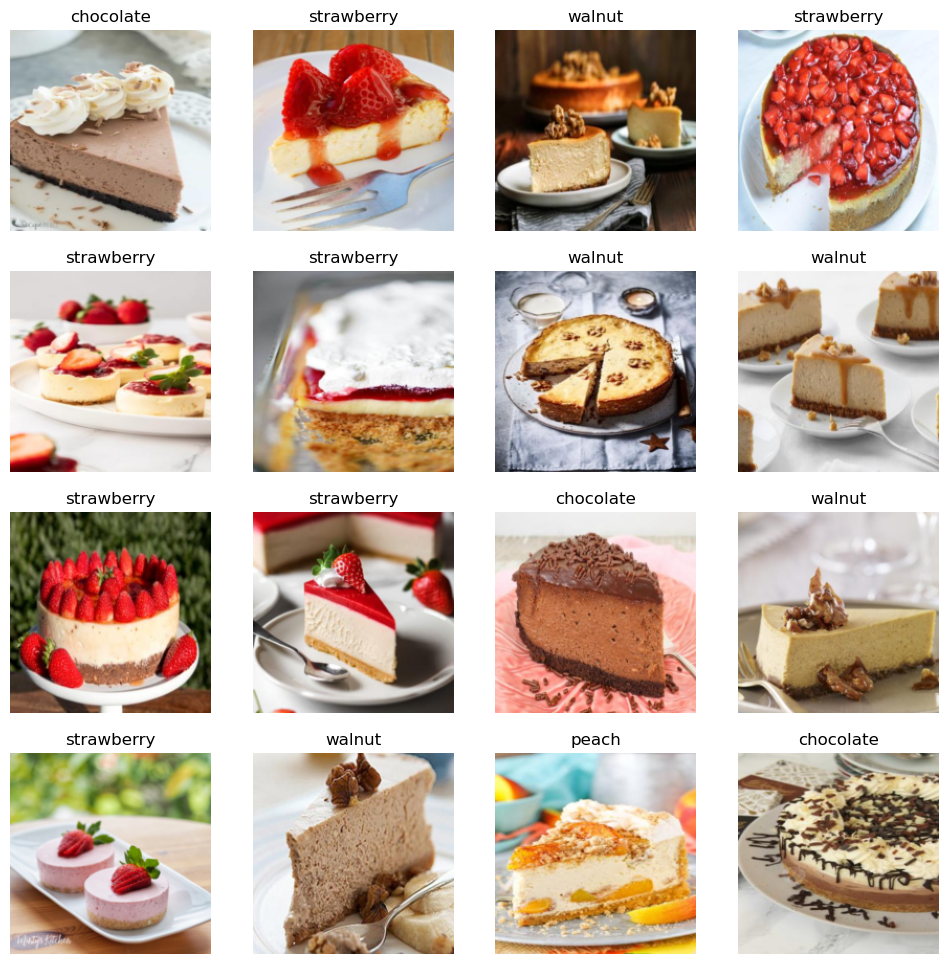

In [4]:
# create a datablock and dataloader
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #technically, smaller training set. Will it impact the result?
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path,bs=32)

dls.show_batch(max_n=16)
# create a learner and fine tune the data with my input data. make the learner predict the data. 
learner = vision_learner(dls,resnet18, metrics=error_rate)
learner.fine_tune(6)

In [5]:
# get the test data
searchImageName = 'walnut cheesecake'
urls = searchImages(searchImageName, 1)

from fastdownload import download_url
dest = f'{searchImageName}.jpg'
download_url(urls[0], dest, show_progress=False)
Image.open(dest).to_thumb(256,256)
# make the learner predict the data. 

strReturn, intReturn, probs = learner.predict(dest) # is probs alphabetically order?
print(f"what is this image?: {strReturn}")
print(f"what is the probability of the image to be {searchImageName}? chocolate :{probs[0]}, peach:{probs[1]}, strawberry:{probs[2]}, walnut:{probs[3]}")

'walnut cheesecake' searching


what is this image?: walnut
what is the probability of the image to be walnut cheesecake? chocolate :6.645951998507371e-06, peach:6.288637450779788e-06, strawberry:2.088543988065794e-05, walnut:0.9999661445617676


In [6]:
#with resnet34
learner = vision_learner(dls,resnet34, metrics=error_rate)
learner.fine_tune(6)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 227MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.241108,1.146022,0.358209,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.940300,0.531817,0.194030,00:36
1,0.635211,0.412509,0.179104,00:36
2,0.425809,0.368536,0.149254,00:36
3,0.324544,0.281210,0.134328,00:37
4,0.250458,0.247550,0.134328,00:37
5,0.195549,0.250533,0.089552,00:36


In [7]:
# get the test data
searchImageName = 'chocolate cheesecake'
urls = searchImages(searchImageName, 1)

from fastdownload import download_url
dest = f'{searchImageName}.jpg'
download_url(urls[0], dest, show_progress=False)
Image.open(dest).to_thumb(256,256)
# make the learner predict the data. 

strReturn, intReturn, probs = learner.predict(dest) # is probs alphabetically order?
print(f"what is this image?: {strReturn}")
print(f"what is the probability of the image to be {searchImageName}? chocolate :{probs[0]}, peach:{probs[1]}, strawberry:{probs[2]}, walnut:{probs[3]}")

'chocolate cheesecake' searching


what is this image?: chocolate
what is the probability of the image to be chocolate cheesecake? chocolate :0.9999852180480957, peach:3.7624151900672587e-06, strawberry:9.589790579411783e-07, walnut:1.001911823550472e-05
